In [1]:
from src.aurele.utils2 import *
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity

# --- global config ---
DATA_DIR          = Path.cwd() / '..' / 'data'
DATA_PATH         = DATA_DIR / "reviews83325.csv"
DATA_URL          = "https://github.com/prayer-position/Project_NLP/releases/latest/download/reviews83325.csv"
MAX_FEATURES      = 300
ZERO_RATIO_THRESH = 0.40   # drop vectors with more than 40% zeros
TOP_K_SIM         = 5      # neighbours for similarity ranking
TOP_K_POP         = 10     # neighbours for popularity count



In [2]:
ensure_data(DATA_DIR, DATA_PATH, DATA_URL)

Data found locally, skipping download


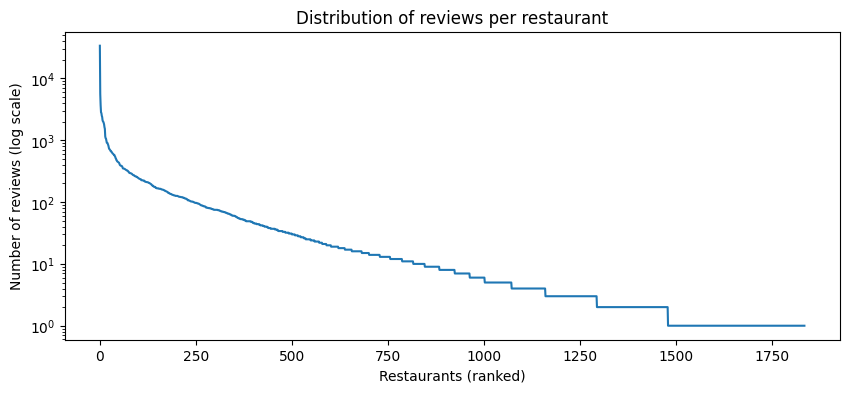

,idplace,review,note
0,188467,personally i think it is the most beautiful sq...,4.517801
1,188468,my old college friend and i booked this beauti...,4.588235
2,188470,being winter and all not a lot going on howeve...,3.682927
3,188471,to call au passe partout a shop is a serious u...,5.000000
4,188472,very old historical place. i attended to exper...,3.250000


In [3]:
# pipe1 : preprocessing 

def preprocess_pipeline(data_path):
    """Load, clean, aggregate. Returns reviews_grouped + idplaces."""
    reviews = load_reviews(data_path)
    reviews = preprocess_reviews(reviews)
    plot_reviews_distribution(reviews)
    reviews_grouped = aggregate_by_place(reviews)
    idplaces = reviews_grouped["idplace"].values
    return reviews_grouped, idplaces


reviews_grouped, idplaces = preprocess_pipeline(DATA_PATH)
reviews_grouped.head()


In [4]:
def tfidf_cosine_pipeline(reviews_grouped, idplaces,
                           max_features=MAX_FEATURES,
                           zero_ratio_thresh=ZERO_RATIO_THRESH):
    """
    TF-IDF → filter sparse vectors → cosine similarity.
    Returns X_tfidf, vectorizer, cos_sim, idplaces (filtered).
    """
    X_tfidf, vectorizer = compute_tfidf(reviews_grouped["review"],
                                        max_features=max_features)
    X_tfidf, idplaces   = filter_sparse_vectors(X_tfidf, idplaces,
                                                zero_ratio_thresh=zero_ratio_thresh)
    cos_sim = cosine_similarity(X_tfidf)
    return X_tfidf, vectorizer, cos_sim, idplaces


X_tfidf, vectorizer, cos_sim, idplaces = tfidf_cosine_pipeline(
    reviews_grouped, idplaces
)

[filter] dropped 1416 / 1835 docs (>40% zeros)


In [5]:
# quick sanity check on the similarity matrix
upper = cos_sim[np.triu_indices_from(cos_sim, k=1)]
print(f"cosine sim — mean: {upper.mean():.3f}  min: {upper.min():.3f}  max: {upper.max():.3f}")

cosine sim — mean: 0.429  min: 0.062  max: 0.996


In [6]:
similarity_index = build_topk_similarity_index(cos_sim, idplaces, k=TOP_K_SIM)
ranking_mean     = rank_places_by_mean_similarity(cos_sim, idplaces)
ranking_top5     = rank_places_by_topk_similarity(cos_sim, idplaces, k=TOP_K_SIM)
top_popular      = count_topk_appearances(cos_sim, idplaces, k=TOP_K_POP)

print("── top 5 by mean similarity ──");  print(ranking_mean.head())
print("── top 5 by top-k similarity ──"); print(ranking_top5.head())
print("── most popular ──");              print(top_popular.head())


── top 5 by mean similarity ──
   idplace  mean_cosine_similarity
0  3600292                0.573733
1   799588                0.572109
2  2035323                0.571982
3   719447                0.571573
4  1034252                0.570289
── top 5 by top-k similarity ──
   idplace  mean_top5_similarity
0   242971              0.979378
1   235555              0.978828
2   189228              0.978357
3   234615              0.976736
4   230461              0.975911
── most popular ──
   idplace  count_in_top10
0  1034252              68
1  1335980              49
2   782261              45
3   799588              42
4  3600292              38


In [7]:
safe_export_similarity(similarity_index, DATA_DIR / "similarity_results.json")

Export cancelled.


Selected words: ['falafel', 'bike', 'versailles', 'class', 'tower', 'ice', 'bus', 'museum']



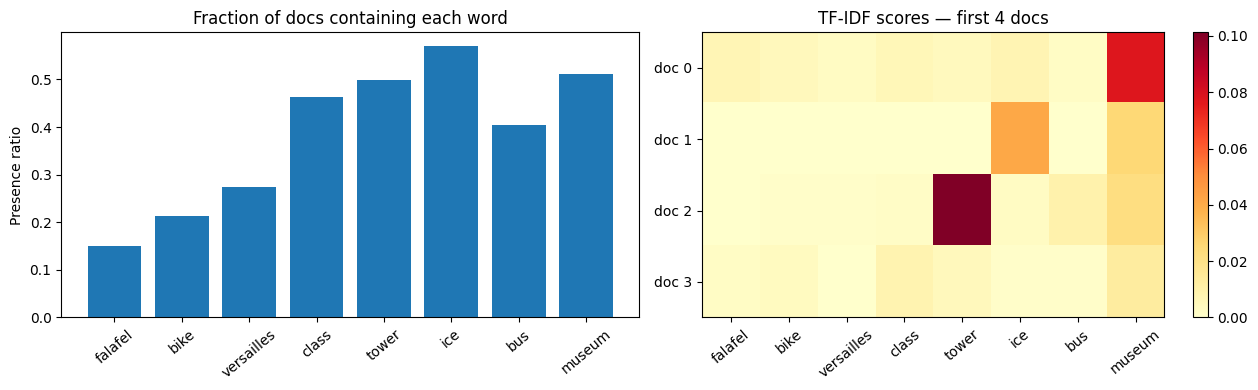

       falafel   bike  versailles  class  tower    ice    bus  museum
doc 0    0.007  0.005       0.003  0.006  0.004  0.007  0.002   0.078
doc 1    0.000  0.000       0.000  0.000  0.000  0.041  0.000   0.025
doc 2    0.000  0.001       0.001  0.002  0.101  0.003  0.009   0.022
doc 3    0.002  0.003       0.000  0.008  0.005  0.001  0.001   0.013


In [8]:
test_tfidf_vocab(X_tfidf, vectorizer)


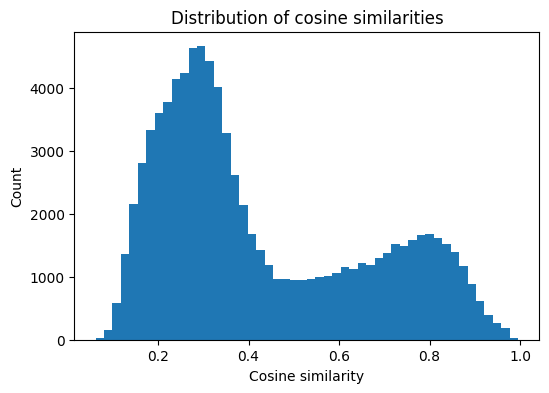

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.hist(upper, bins=50)
plt.xlabel("Cosine similarity")
plt.ylabel("Count")
plt.title("Distribution of cosine similarities")
plt.show()

In [10]:
def rank_places_by_topk_similarity(cos_sim, idplaces, k=5):
    scores = []

    for i in range(len(idplaces)):
        sims = cos_sim[i]
        order = np.argsort(sims)[::-1]
        order = order[order != i][:k]

        score = sims[order].mean()

        scores.append(score)

    df = pd.DataFrame({
        "idplace": idplaces,
        f"mean_top{k}_similarity": scores
    })

    return df.sort_values(
        by=f"mean_top{k}_similarity",
        ascending=False
    ).reset_index(drop=True)

In [11]:
ranking_top5 = rank_places_by_topk_similarity(cos_sim, idplaces, k=5)
ranking_top5.head(10)

,idplace,mean_top5_similarity
0,242971,0.979378
1,235555,0.978828
2,189228,0.978357
3,234615,0.976736
4,230461,0.975911
5,194223,0.975255
6,235552,0.974611
7,636096,0.974601
8,596179,0.974407
9,189693,0.973412


In [12]:
import numpy as np
import pandas as pd

def count_topk_appearances(cos_sim, idplaces, k=3):
    counts = {idp: 0 for idp in idplaces}

    for i in range(len(idplaces)):
        sims = cos_sim[i]
        order = np.argsort(sims)[::-1]

        # enlever soi-même
        order = order[order != i][:k]

        for idx in order:
            counts[idplaces[idx]] += 1

    df = pd.DataFrame({
        "idplace": list(counts.keys()),
        f"count_in_top{k}": list(counts.values())
    })

    return df.sort_values(
        by=f"count_in_top{k}",
        ascending=False
    ).reset_index(drop=True)

In [13]:
top3_popularity = count_topk_appearances(cos_sim, idplaces, k=10)
top3_popularity.head(10)

,idplace,count_in_top10
0,1034252,68
1,1335980,49
2,782261,45
3,799588,42
4,3600292,38
5,2261934,37
6,719447,37
7,714918,34
8,983554,34
9,786517,33


In [14]:
# print les review de ce id 11860583
print(reviews_grouped[reviews_grouped["idplace"] == 11860583]["review"].values[0])

murilo delivered what we wanted a private walking tour of montmatre taking us to places off the beaten track and showing us places and telling us things we would not have been able to find learn on our own or from a guide book. his knowledge of paris was excellent all self taught but detailed and thorough. our tour lasted just under hours and he dropped us at a great place for lunch. these tours are personal and not like those in some countries where you are taken to a friends shop etc. murilo loves photos and photography offering some great tips. excellent english by the way. give it a go.we enjoyed the tour with murilo very much. it was a fantastic mix of the classic landmarks of paris with some nice surprises on the way. highly recommendable.we absolutely loved our tour with william. he guided us through low traffic passages and smaller streets to experience a more intimate view of paris. he s a talented photographer and helped us get loads of fantastic pictures. we enjoyed every mi

In [21]:
bm25_reco_fast = compute_bm25_fast(reviews_grouped["review"], reviews_grouped["idplace"])
bm25_reco_fast.head()

Filtrage des tokens (Vocabulaire limité à 80 mots)...
Initialisation BM25...
Calcul des recommandations (Vectorisé)...


,idplace,top1_id,top1_sim,top2_id,top2_sim,top3_id,top3_sim,top4_id,top4_sim,top5_id,top5_sim
0,188467,292257,5721.3302,209761,5568.4985,1515570,5470.6981,188738,5438.9627,188745,5431.7244
1,188468,1515570,72.7337,239650,71.6771,236512,71.0699,308527,70.8636,235552,69.8065
2,188470,209761,153.1004,292257,149.0357,188467,145.1384,1035159,144.8286,1515570,141.9030
3,188471,4551153,7.4042,549934,7.3756,2479112,7.3419,1464432,7.3371,188758,7.3320
4,188472,3406006,22.6222,188679,22.2413,2397509,21.8188,194271,21.7237,194312,21.4276


In [22]:
safe_export_similarity(bm25_reco_fast, output_path = DATA_DIR / "BM25_similarity.json")

[export] 1829 places written to e:\Documents\A4 - DIA\DIA\Project_NLP\notebooks\..\data\BM25_similarity.json
Successfully exported to e:\Documents\A4 - DIA\DIA\Project_NLP\notebooks\..\data\BM25_similarity.json
